In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, cohen_kappa_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score, f1_score, roc_auc_score, roc_curve
import numpy as np
import pandas as pd
import math
from joblib import dump, load
from helper import index as slowHelpers
import random
import pickle

from helper import fast as fs
from skimage.restoration import denoise_bilateral

In [2]:
%%time
#np.save("proba.npy" ,proba)
proba = np.load("proba.npy")
#plt.imshow(proba)
proba_post_process = fs.probaPostProcess(proba, 6,0.25)

started: 17 56
deNoise done: 18 0
0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
gapFill done: 18 1
(2997, 2620)
probaToZone done: 18 1
Wall time: 5min 43s


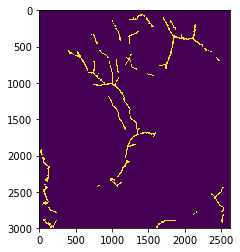

In [3]:
plt.imshow(proba_post_process)

In [42]:
def foo(list_of_zones):
    frames = np.empty(len(list_of_zones), dtype=object)
    for i, zone_file_name in enumerate(list_of_zones):
        zone = pd.read_pickle(zone_file_name)
        mask = masks[i] 
        
        mask = slowHelpers.createBalancedMask(zone["label_3m"].values.reshape((2997,2620)), 3, 5)
        
        mask = np.where(np.invert(mask.reshape(-1)))
        
        zone.drop(zone.index[mask], inplace=True)
        frames[i] = zone
    return pd.concat(frames)

In [126]:
def bar(clf, dataset):
    """clf is a classifier and dataset is a dataframe of an entire zone"""
    proba_arr = clf.predict_proba(dataset.loc[:, dataset.columns != "label_3m"])
    y = dataset["label_3m"]
    np.where(a > 0.9, 1,0 )
    proba_arr = proba_arr[:,1:].reshape(2997,2620)

In [43]:
#dataset = foo(["zone_1.pickle","zone_2.pickle","zone_3.pickle","zone_4.pickle","zone_5.pickle","zone_6.pickle", "zone_7.pickle", "zone_9.pickle"])
dataset = foo(["zone_1.pickle", "zone_9.pickle", "zone_2.pickle", "zone_4.pickle"])
#dataset = foo(["zone_10.pickle"])

In [44]:
dataset.values.shape

(934185, 49)

In [45]:
X_train = dataset.loc[:, dataset.columns != "label_3m"]
y_train = dataset["label_3m"]
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.001, random_state=42)

In [46]:
compute_class_weight("balanced", np.array([0,1]), y_test)

array([ 0.51398738, 18.37325209])

In [47]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42 , class_weight={0:0.45, 1: 55})


clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.45, 1: 55},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [4]:
#dump(clf, "classifier_100_trees_2_entirezones_classweight_balanced.joblib")
clf = load("classifier_100_trees_2_entirezones_classweight_balanced.joblib")
#clf = load("classifier_newmask_200.joblib")

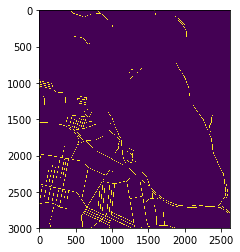

In [48]:
datasetZone10 = pd.read_pickle("zone_7.pickle")
X_test = datasetZone10.loc[:, datasetZone10.columns != "label_3m"]
y_test = datasetZone10["label_3m"]
plt.imshow(y_test.values.reshape((2997,2620)))

Accuracy score              0.9728775849640989
Recall score                0.6018372924505344
Area under curve score(AUC) 0.5570332468184497
Average precision score(AP) 0.3125928838146678
ROC                         0.7925473209207815
Cohen's kappa               0.5331827971828309
Confusion matrix
 [[7510568  127888]
 [  85081  128603]]


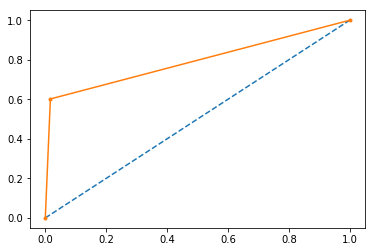

In [49]:
#from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
# auc, average_precision_score, f1_score
y_pred = clf.predict(X_test)
print("Accuracy score             ",accuracy_score(y_test,y_pred))
print("Recall score               ",recall_score(y_test,y_pred))

precision, recall, threshholds = precision_recall_curve(y_test,y_pred)
auc_score = auc(recall, precision)
print("Area under curve score(AUC)", auc_score)
ap = average_precision_score(y_test, y_pred)
print("Average precision score(AP)", ap)
print("ROC                        ", roc_auc_score(y_test, y_pred))

print("Cohen's kappa              ", cohen_kappa_score(y_test,y_pred))
print("Confusion matrix\n", confusion_matrix(y_test,y_pred))


fpr, tpr, thresholds = roc_curve(y_test,y_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

In [50]:
importances = clf.feature_importances_
feature_names = dataset.columns.values.tolist()[1:]
tuple_features = [(feature_names[i], importance) for i, importance in enumerate(importances)]
tuple_features.sort(key=lambda x: x[1], reverse=True)

for f in range(X_test.shape[1]):
    print("{:>2}. {:<20}  {:.2f} %".format(f + 1, tuple_features[f][0], tuple_features[f][1]*100))

 1. impundment_amplified  7.29 %
 2. slope_non_ditch       5.42 %
 3. slope_std_6           3.43 %
 4. skyview_non_ditch     3.36 %
 5. skyview_gabor         3.34 %
 6. hpmf_filter           3.15 %
 7. impundment_std_6      3.14 %
 8. impundment_mean_6     2.99 %
 9. hpmf_mean_6           2.84 %
10. slope_mean_6          2.83 %
11. slope_median_6        2.59 %
12. hpmf_std_6            2.57 %
13. skyview_std_6         2.55 %
14. skyview_median_6      2.51 %
15. skyview_mean_6        2.42 %
16. hpmf_gabor            2.39 %
17. impundment_mean_4     2.21 %
18. impundment_median_6   2.14 %
19. impundment_mean_3     1.85 %
20. skyview_mean_4        1.85 %
21. skyview_median_4      1.84 %
22. hpmf_mean_4           1.76 %
23. hpmf_skew_2           1.73 %
24. skyview_mean_3        1.69 %
25. slope_mean_4          1.66 %
26. slope_median_4        1.65 %
27. skyview_median_2      1.62 %
28. slope_skew_2          1.62 %
29. skyview_skew_2        1.61 %
30. impundment_skew_2     1.57 %
31. skyvie

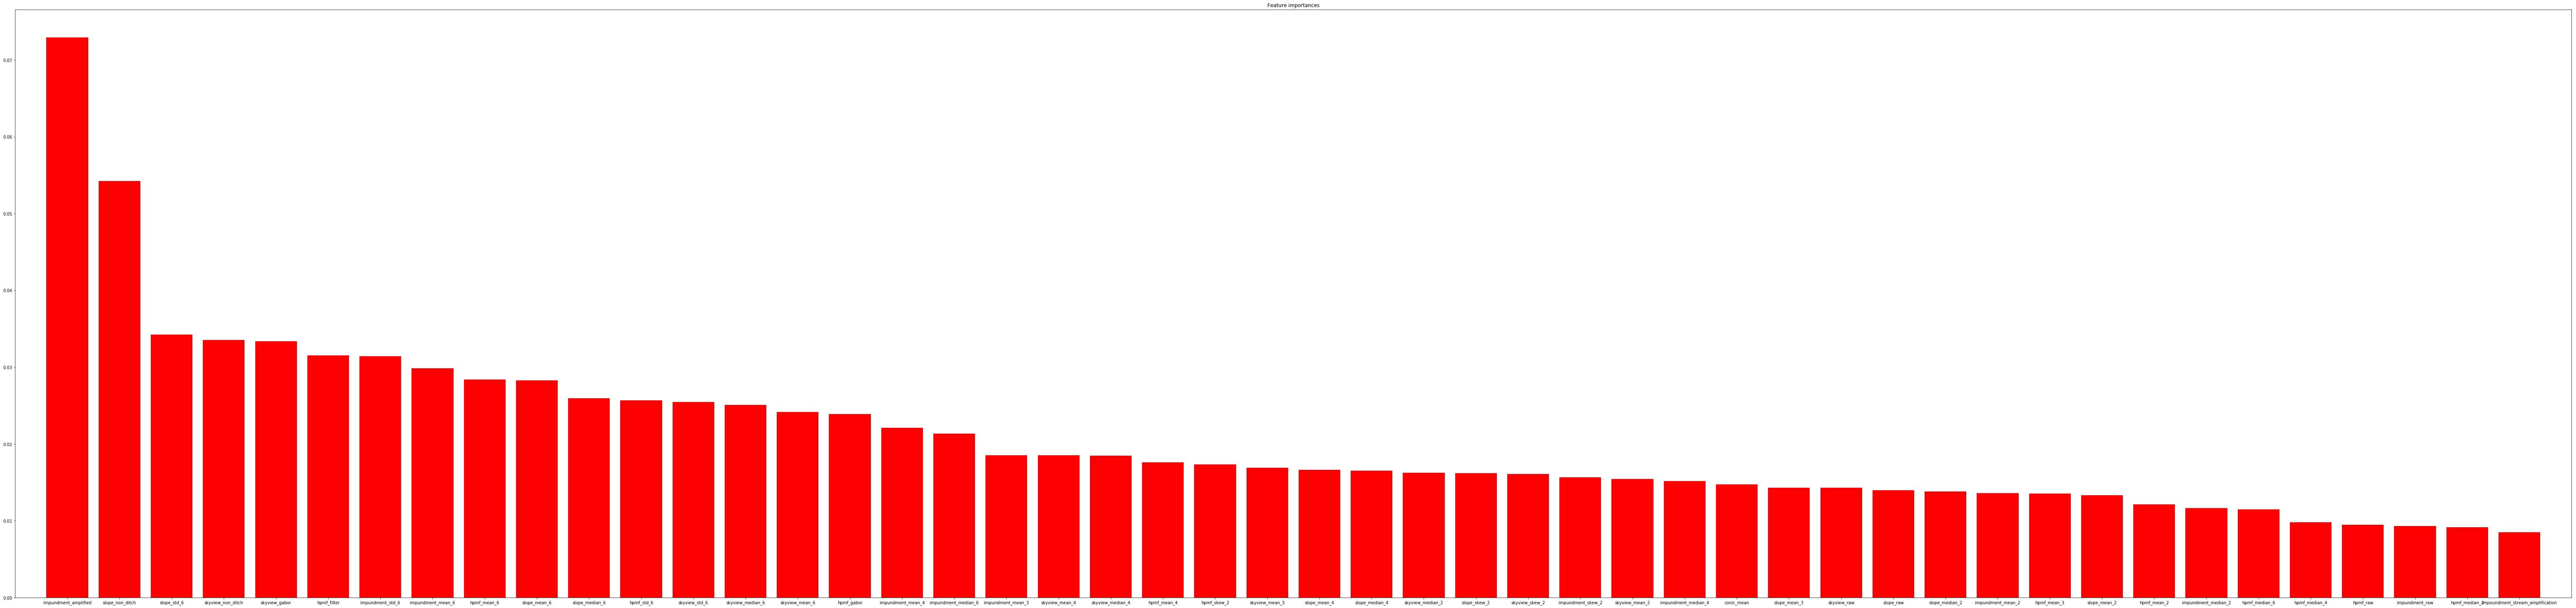

In [51]:
plt.figure(num=None, figsize=(110,26), facecolor='w', edgecolor='k')
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), [x[1] for x in tuple_features],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), [x[0] for x in tuple_features])
plt.xlim([-1, X_train.shape[1]])
plt.show()

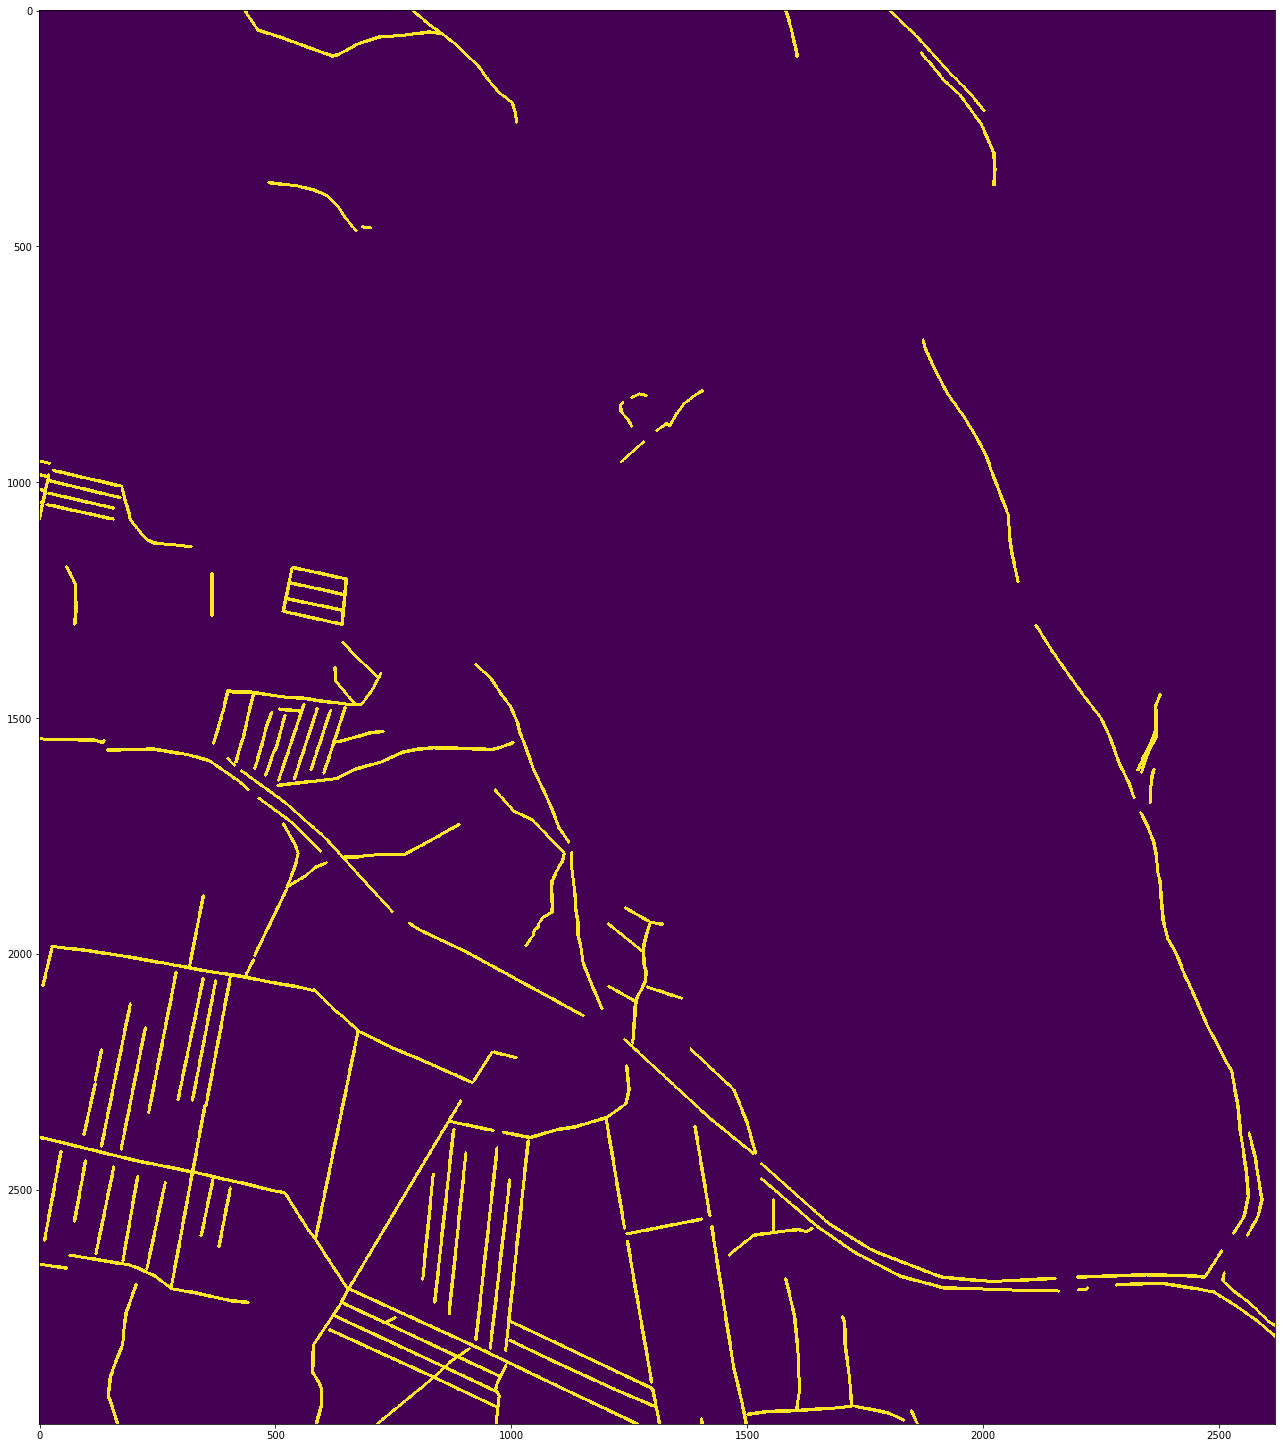

In [52]:
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(y_test.values.reshape(2997,2620))

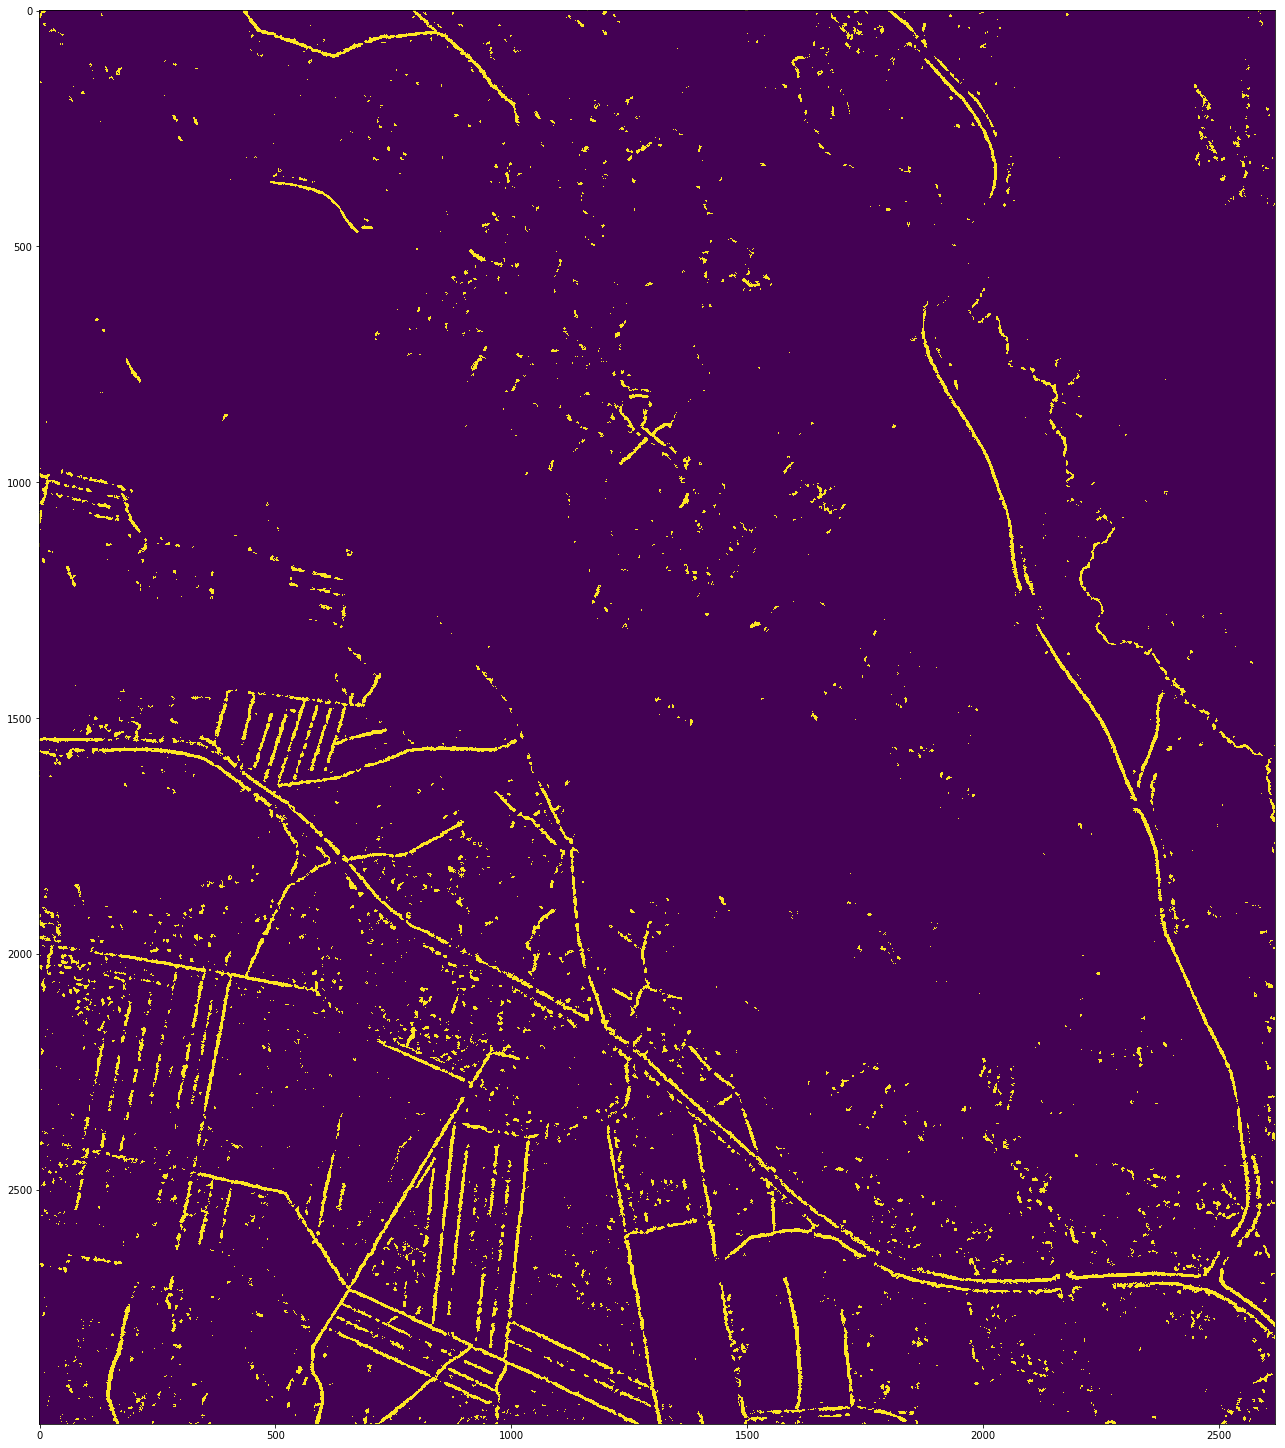

In [53]:
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(y_pred.reshape(2997,2620))

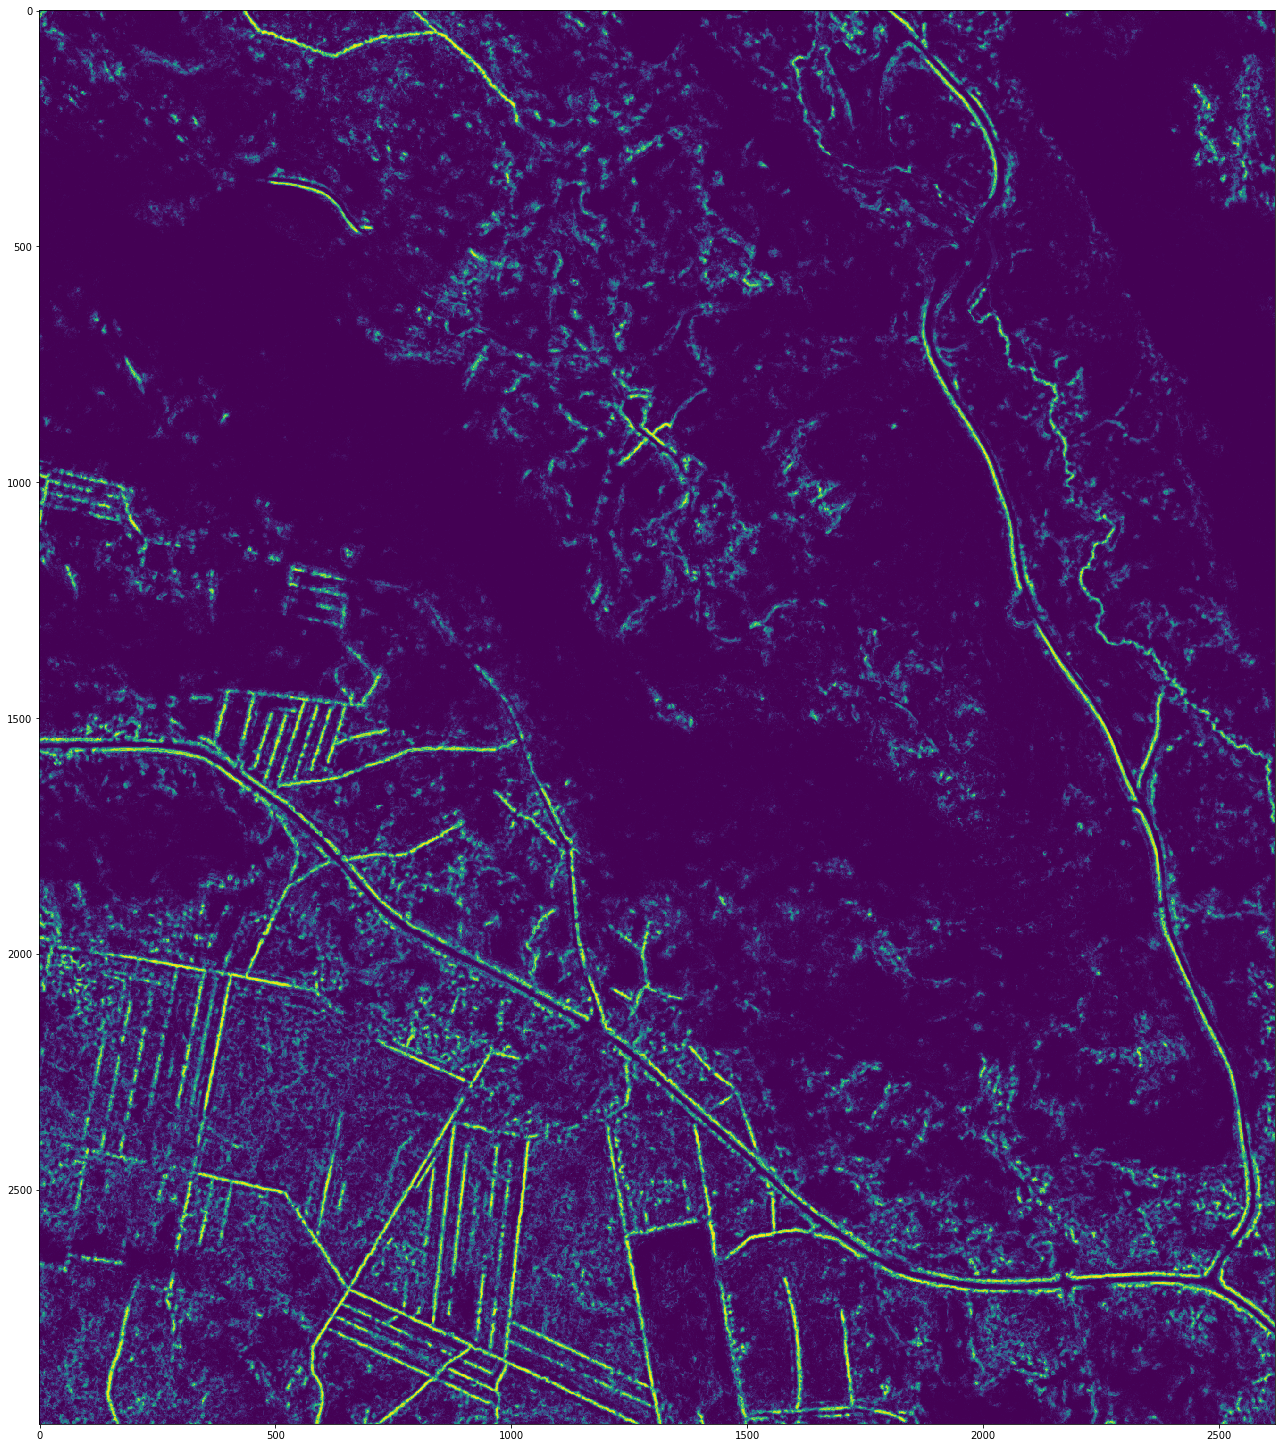

In [54]:
proba = clf.predict_proba(X_test)[:,1:].reshape(2997,2620)
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
#proba[proba > 0.3] = 1
#proba[proba < 0.3] = 0
plt.imshow(proba)

In [40]:
def create_balanced_mask(clf, zone_number):
    datasetZone10 = pd.read_pickle(f"zone_{zone_number}.pickle")
    X_test = datasetZone10.loc[:, datasetZone10.columns != "label_3m"]
    y_test = datasetZone10["label_3m"]
    proba_arr = clf.predict_proba(X_test)
    _proba_arr = proba_arr[:,1:].reshape(-1)
    
    test_mask = np.where(_proba_arr > 0.55 , 1, 0 )
    test_mask = np.where(test_mask == y_test, test_mask, 1)

    _rand = np.random.randint(15, size=(2997,2620)).reshape(-1)
    for i,item in enumerate(_rand):
        if item == 1: 
            test_mask[i] = 1

    print("ratio {:.2f}, % zone coverd {:.2f}".format( np.count_nonzero(y_test == 1)  / np.count_nonzero(test_mask == 1), np.count_nonzero(test_mask == 1) / (2997*2620)))

    #plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
    #plt.imshow(test_mask.reshape(2997,2620))
    return test_mask

In [41]:
try:
    masks = pickle.load(open("masks.pickle", "rb"))
except (OSError, IOError) as e:
    masks =  [create_balanced_mask(clf, i) for i in range(1,11)]
    masks = [item.astype(bool) for item in masks]
    pickle.dump(masks, open("masks.pickle", "wb"))
 
    
 
#pickle.dump(masks, open("masks.pickle", "wb"))

ratio 0.10, % zone coverd 0.07
ratio 0.06, % zone coverd 0.07
ratio 0.09, % zone coverd 0.07
ratio 0.23, % zone coverd 0.09
ratio 0.20, % zone coverd 0.08
ratio 0.16, % zone coverd 0.08
ratio 0.29, % zone coverd 0.09
ratio 0.13, % zone coverd 0.08
ratio 0.22, % zone coverd 0.08
ratio 0.33, % zone coverd 0.10


ratio 0.22, % zone coverd 0.12


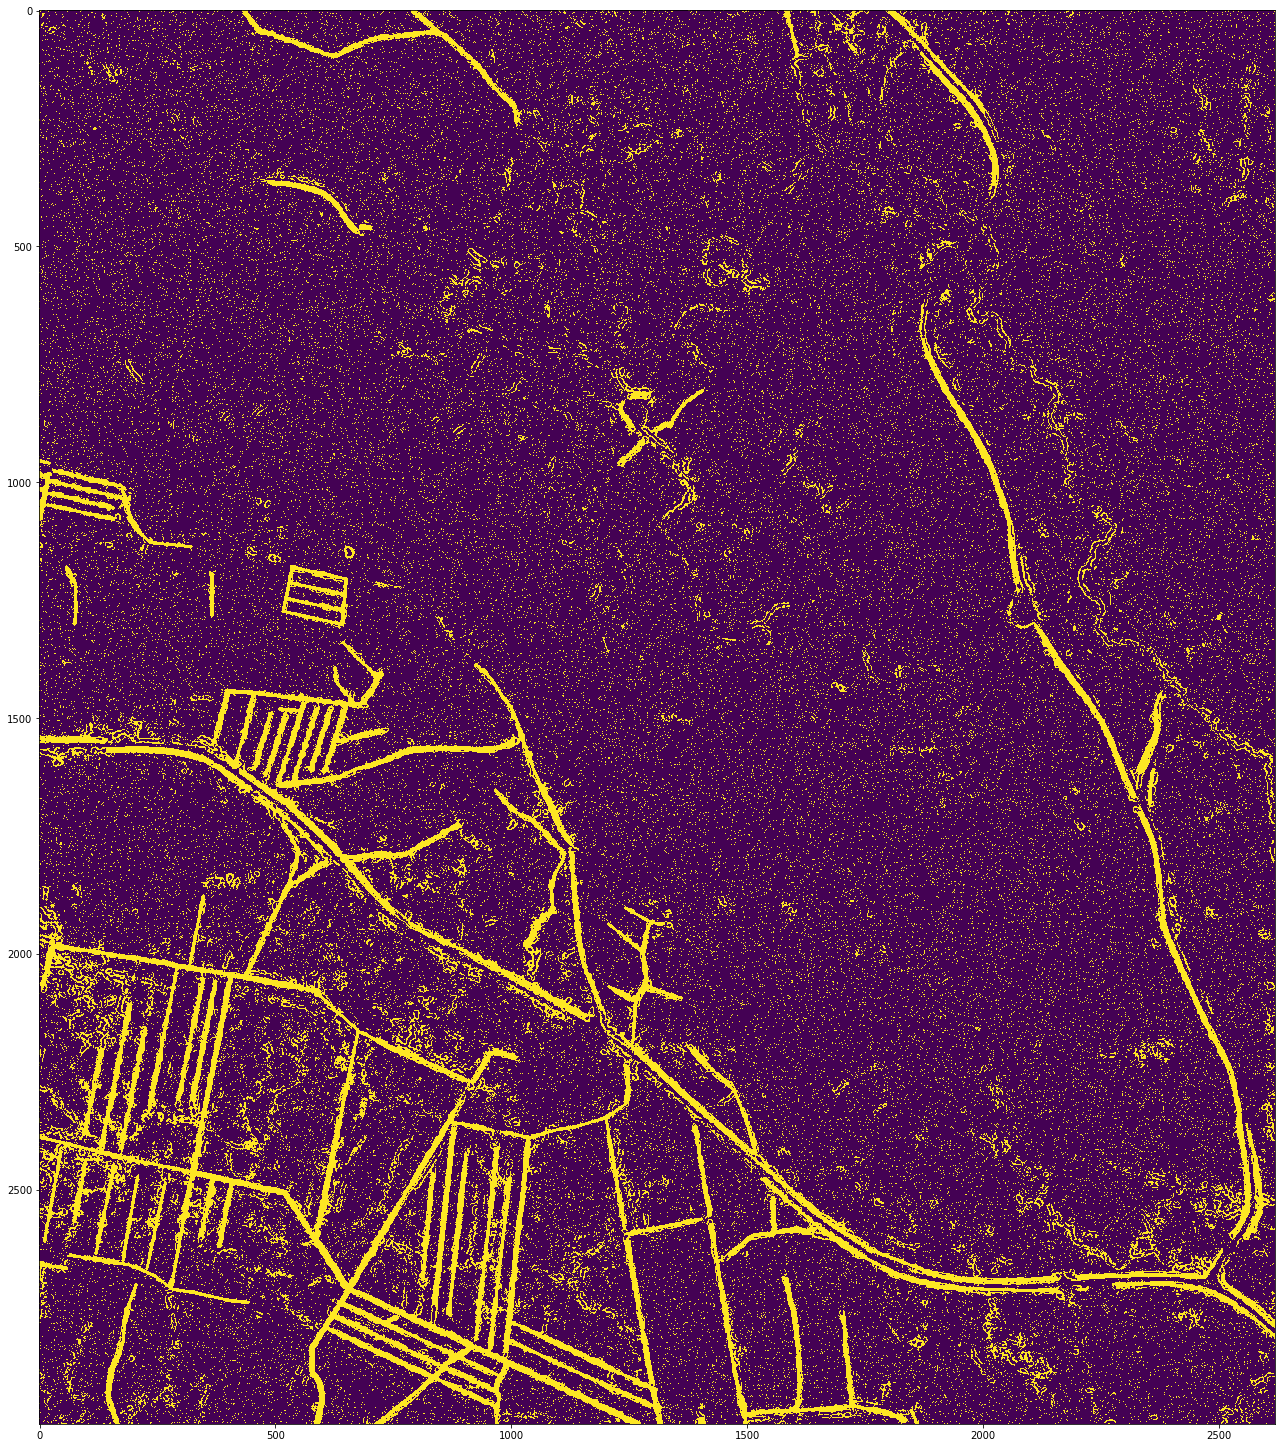

In [39]:
bad_clf = load("classifier.joblib")
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(create_balanced_mask(bad_clf, 7).reshape(2997,2620))

In [55]:
%%time
proba_post_process = fs.probaPostProcess(proba, 6,0.25)

started: 19 58
deNoise done: 20 3
0
500
1000
1500
2000
2500
0
500
1000
1500
2000
2500
gapFill done: 20 3
(2997, 2620)
probaToZone done: 20 3
Wall time: 5min 55s


Accuracy score              0.9754153644738887
Recall score                0.5233101214878044
Area under curve score(AUC) 0.5435619356824942
Average precision score(AP) 0.30123324759708486
ROC                         0.7556865116025574
Cohen's kappa               0.5241040763300018
Confusion matrix
 [[7547275   91181]
 [ 101861  111823]]


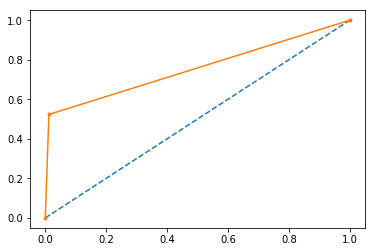

In [56]:
#from sklearn.metrics import accuracy_score,recall_score,confusion_matrix
# auc, average_precision_score, f1_score
y_pred = proba_post_process.astype(int).reshape(-1)
print("Accuracy score             ", accuracy_score(y_test,y_pred))
print("Recall score               ", recall_score(y_test,y_pred))

precision, recall, threshholds = precision_recall_curve(y_test,y_pred)
auc_score = auc(recall, precision)
print("Area under curve score(AUC)", auc_score)
ap = average_precision_score(y_test, y_pred)
print("Average precision score(AP)", ap)
print("ROC                        ", roc_auc_score(y_test, y_pred))

print("Cohen's kappa              ", cohen_kappa_score(y_test,y_pred))
print("Confusion matrix\n", confusion_matrix(y_test,y_pred))


fpr, tpr, thresholds = roc_curve(y_test,y_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()

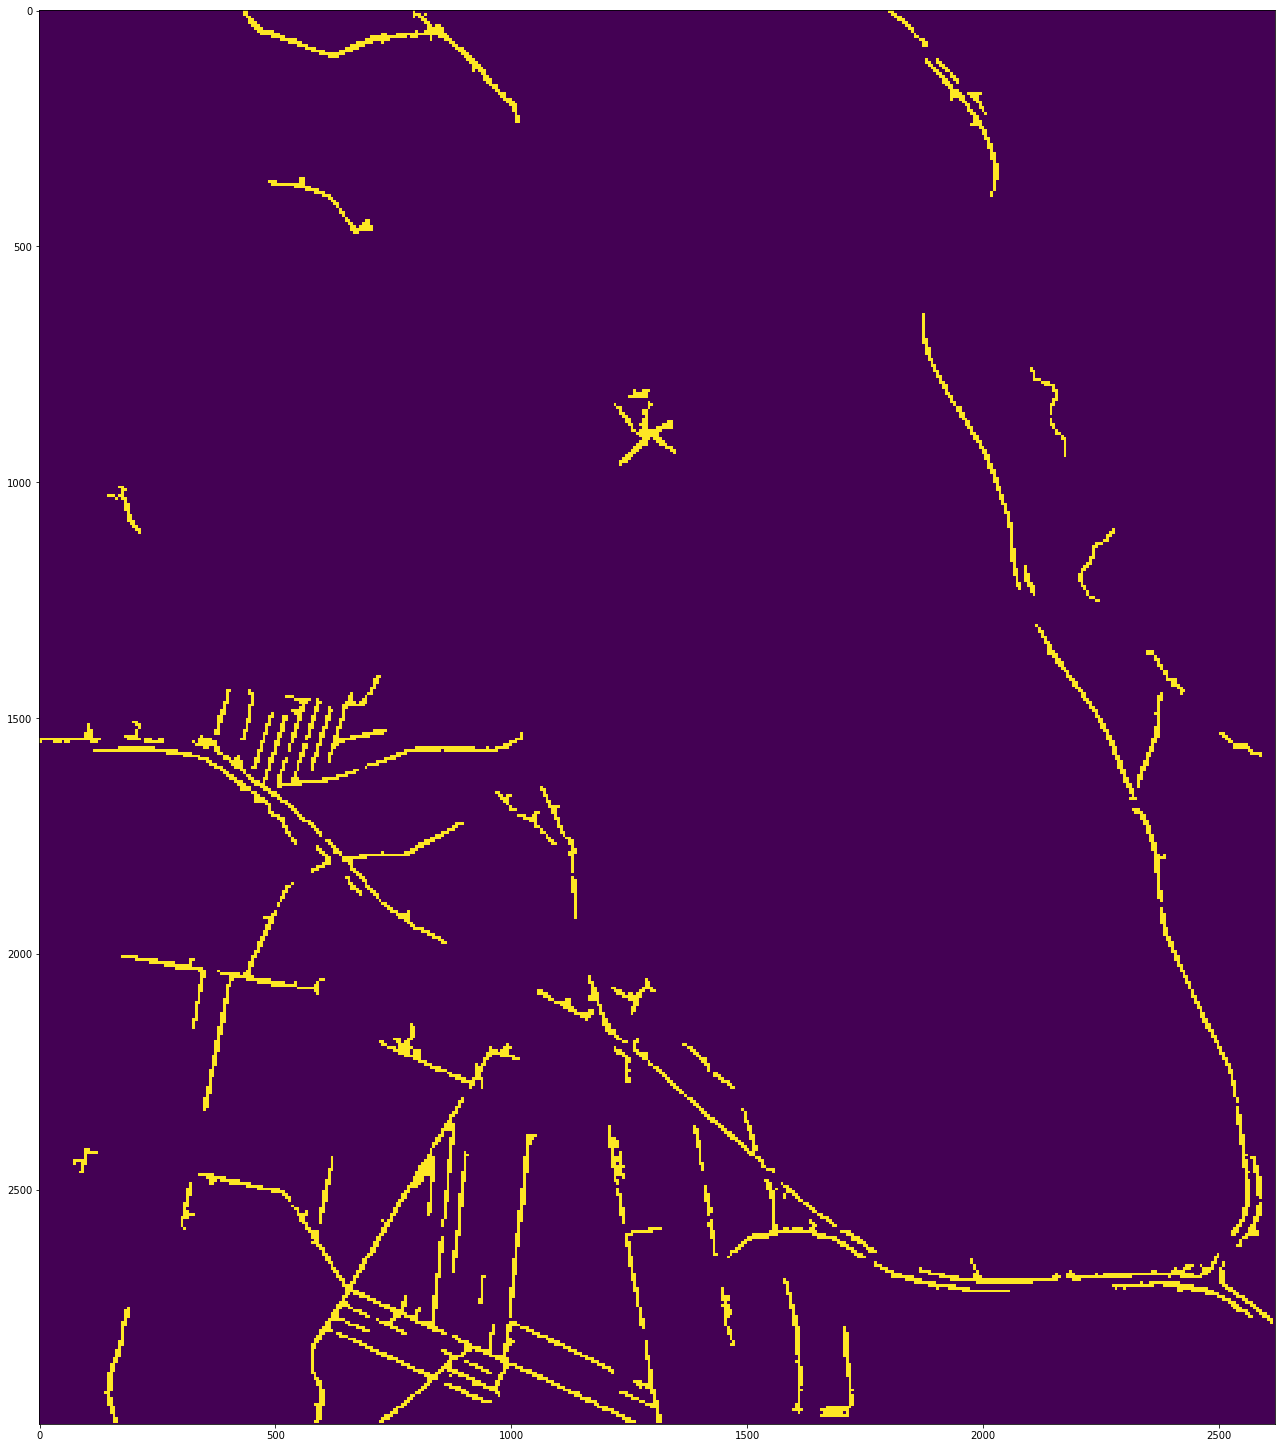

In [57]:
plt.figure(num=None, figsize=(28,26), facecolor='w', edgecolor='k')
plt.imshow(proba_post_process)